In [36]:
!pip install pennylane qiskit torch numpy pandas scikit-learn matplotlib seaborn
!pip install pylatexenc
!pip install --upgrade pennylane matplotlib

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os

file_path = '/content/drive/MyDrive/datasets/heart_disease_uci.csv'
df = pd.read_csv(file_path)
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [39]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

In [40]:
# Hyperparams

LABEL_CANDIDATES = ["target", "label", "heart_disease", "condition", "output"]
RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15
BATCH_SIZE = 16
N_EPOCHS = 100
LEARNING_RATE = 1e-3
N_QUBITS = 4
N_LAYERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# Utility: find label column

def detect_label_column(df):
    for name in LABEL_CANDIDATES:
        if name in df.columns:
            return name
    # fallback: try common single binary column (0/1)
    for col in df.columns:
        if df[col].dropna().isin([0,1]).all():
            return col
    raise ValueError("Could not detect label column. Rename the label to one of: " + ", ".join(LABEL_CANDIDATES))

In [42]:
# 1) Load & preprocess

df = pd.read_csv(file_path)
label_col = detect_label_column(df)
print(f"Detected label column: {label_col}")
for c in ["id", "dataset", "patient_id"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

X_raw = df.drop(columns=[label_col])
y_raw = df[label_col].copy()

for col in X_raw.select_dtypes(include=["object", "category"]).columns:
    X_raw[col] = X_raw[col].astype("category").cat.codes.replace({-1: np.nan})

imp = SimpleImputer(strategy="median")
X_imputed = imp.fit_transform(X_raw)
y_imputed = y_raw.copy()
mask = ~pd.isnull(y_imputed)
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


Detected label column: fbs


In [43]:
# PCA
pca = PCA(n_components=N_QUBITS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio of PCA (4 components):", pca.explained_variance_ratio_)

Explained variance ratio of PCA (4 components): [0.22901386 0.13311822 0.09242665 0.08296313]


In [44]:
# 2) Train / Val / Test split

testval_size = TEST_SIZE + VAL_SIZE
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pca, y_imputed, test_size=testval_size, random_state=RANDOM_STATE, stratify=y_imputed
)

relative_test = TEST_SIZE / (TEST_SIZE + VAL_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=relative_test, random_state=RANDOM_STATE, stratify=y_temp
)

print("Sizes -> Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (N,1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE, shuffle=False)

Sizes -> Train: 581 Val: 124 Test: 125


In [45]:
# 3) Define PennyLane QNode & Torch Layer

dev = qml.device("default.qubit", wires=N_QUBITS)

def feature_map(x):
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)


def ansatz(params):
    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        for i in range(N_QUBITS - 1): # simple entangling chain
            qml.CNOT(wires=[i, i+1])
        qml.CNOT(wires=[N_QUBITS-1, 0])

@qml.qnode(dev, interface="torch") # QNode
def qnode(inputs, params):
    feature_map(inputs)
    ansatz(params)
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"params": (N_LAYERS, N_QUBITS, 3)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

class VQCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qlayer

    def forward(self, x):
        batch_probs = []
        for i in range(x.shape[0]):
            expval = self.qlayer(x[i])
            prob = (1.0 - expval) / 2.0
            batch_probs.append(prob)
        out = torch.stack(batch_probs).float()
        return out.unsqueeze(1)

model = VQCModel().to(DEVICE)

In [46]:
# 4) Loss & Optimizer (PyTorch)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [47]:
# 5) Training loop with validation

def evaluate(loader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds = model(Xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
            preds_bin = (preds > 0.5).float()
            correct += (preds_bin == yb).sum().item()
            total += yb.numel()
    return np.mean(losses), correct / total

best_val_acc = 0.0
best_state = None
history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    batch_losses = []
    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)
    val_loss, val_acc = evaluate(val_loader)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.clone().cpu() for k, v in model.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{N_EPOCHS} — train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

Epoch   1/100 — train_loss: 0.7210 | val_loss: 0.7152 | val_acc: 0.5806
Epoch   5/100 — train_loss: 0.7092 | val_loss: 0.7057 | val_acc: 0.5968
Epoch  10/100 — train_loss: 0.7109 | val_loss: 0.6966 | val_acc: 0.6048
Epoch  15/100 — train_loss: 0.6921 | val_loss: 0.6897 | val_acc: 0.5968
Epoch  20/100 — train_loss: 0.6880 | val_loss: 0.6845 | val_acc: 0.5968
Epoch  25/100 — train_loss: 0.6800 | val_loss: 0.6797 | val_acc: 0.5887
Epoch  30/100 — train_loss: 0.6821 | val_loss: 0.6742 | val_acc: 0.5968
Epoch  35/100 — train_loss: 0.6750 | val_loss: 0.6670 | val_acc: 0.6129
Epoch  40/100 — train_loss: 0.6687 | val_loss: 0.6574 | val_acc: 0.6371
Epoch  45/100 — train_loss: 0.6608 | val_loss: 0.6429 | val_acc: 0.6290
Epoch  50/100 — train_loss: 0.6500 | val_loss: 0.6225 | val_acc: 0.6290
Epoch  55/100 — train_loss: 0.6366 | val_loss: 0.5952 | val_acc: 0.6613
Epoch  60/100 — train_loss: 0.6225 | val_loss: 0.5680 | val_acc: 0.7097
Epoch  65/100 — train_loss: 0.6121 | val_loss: 0.5477 | val_acc:

In [48]:

# 6) Test evaluation (using best model)

if best_state is not None:
    model.load_state_dict(best_state)
test_loss, test_acc = evaluate(test_loader)
print(f"\nFinal Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

# Save model and artifacts
torch.save({
    "model_state_dict": model.state_dict(),
    "scaler": scaler,
    "pca": pca,
    "imputer": imp,
    "label_col": label_col
}, "vqc_heart_checkpoint.pth")

print("Saved checkpoint: vqc_heart_checkpoint.pth")

# summary

print("\n--- Mentor Summary (FeatureMap, Ansatz, Measurement, Gradient) ---\n")
print("1) FeatureMap: angle embedding (RY) mapping each of the 4 PCA components to RY rotations on 4 qubits.")
print("2) Ansatz: layered RX/RY/RZ per wire with CNOT entangling chain across qubits (N_LAYERS layers).")
print("3) Measurement: expectation value of Pauli-Z on qubit 0 (mapped to probability p = (1 - <Z>)/2).")
print("4) Gradient Descent: PyTorch Adam optimizer updates parameters; gradients flow via PennyLane's parameter-shift through qnode and qml.qnn.TorchLayer enabling autograd compatibility.")



Final Test — loss: 0.5779 | acc: 0.7040
Saved checkpoint: vqc_heart_checkpoint.pth

--- Mentor Summary (FeatureMap, Ansatz, Measurement, Gradient) ---

1) FeatureMap: angle embedding (RY) mapping each of the 4 PCA components to RY rotations on 4 qubits.
2) Ansatz: layered RX/RY/RZ per wire with CNOT entangling chain across qubits (N_LAYERS layers).
3) Measurement: expectation value of Pauli-Z on qubit 0 (mapped to probability p = (1 - <Z>)/2).
4) Gradient Descent: PyTorch Adam optimizer updates parameters; gradients flow via PennyLane's parameter-shift through qnode and qml.qnn.TorchLayer enabling autograd compatibility.


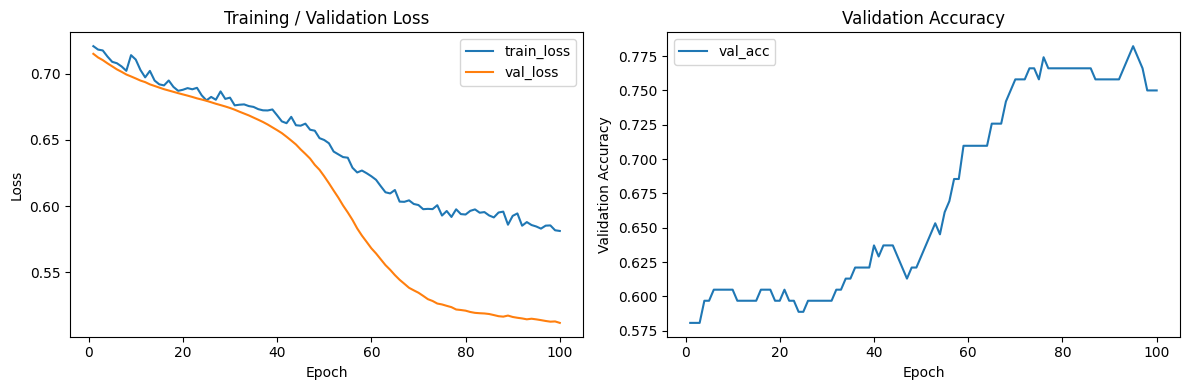

In [49]:
epochs = np.arange(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
def plot_decision_boundary(model, X_train, X_test, y_test, device=DEVICE):

    X_vis_train = X_train[:, :2]
    X_vis_test = X_test[:, :2]

    x_min, x_max = X_vis_train[:,0].min() - .5, X_vis_train[:,0].max() + .5
    y_min, y_max = X_vis_train[:,1].min() - .5, X_vis_train[:,1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    other_mean = X_train.mean(axis=0)
    grid_points = np.c_[xx.ravel(), yy.ravel(),
                        np.full_like(xx.ravel(), other_mean[2]),
                        np.full_like(xx.ravel(), other_mean[3])]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy().reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, preds, 50, cmap="coolwarm", alpha=0.6)
    plt.contour(xx, yy, preds, levels=[0.5], colors="k", linewidths=1.5)
    plt.scatter(X_vis_test[:,0], X_vis_test[:,1], c=y_test.flatten(), cmap="bwr", edgecolor='k', s=60)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Decision boundary (p(class1)) and test points")
    plt.colorbar(label="Predicted probability (class 1)")
    plt.show()


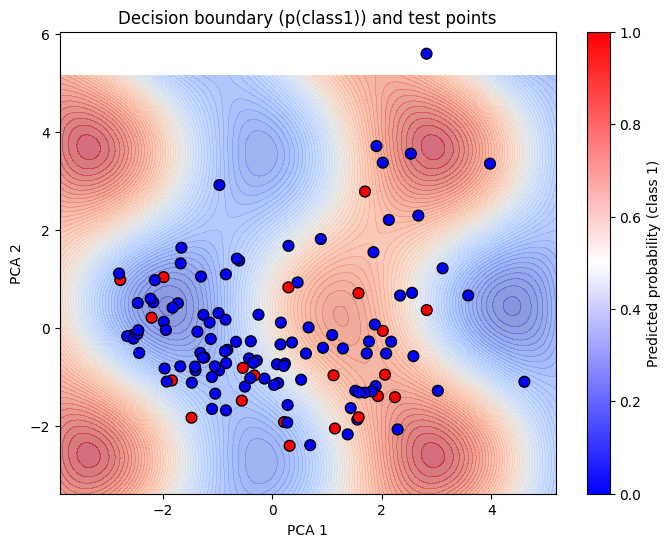

In [54]:
plot_decision_boundary(model, X_train, X_test, y_test)


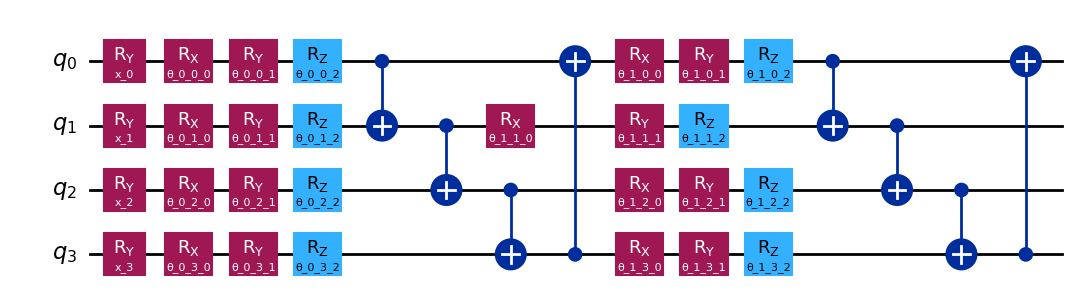

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

def build_qiskit_circuit(n_qubits=4, n_layers=N_LAYERS, example_input=None):
    qc = QuantumCircuit(n_qubits)
  
    input_params = [Parameter(f'x_{i}') for i in range(n_qubits)]

    if example_input is None:
       
        for i in range(n_qubits):
            qc.ry(input_params[i], i)
    else:
        
        for i in range(n_qubits):
            qc.ry(float(example_input[i]), i)

    
    params = [
        [
            [Parameter(f'θ_{l}_{i}_{k}') for k in range(3)]
            for i in range(n_qubits)
        ]
        for l in range(n_layers)
    ]

    for l in range(n_layers):
        for i in range(n_qubits):
            qc.rx(params[l][i][0], i)
            qc.ry(params[l][i][1], i)
            qc.rz(params[l][i][2], i)

    
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        qc.cx(n_qubits - 1, 0) 

    return qc


qc = build_qiskit_circuit(n_qubits=N_QUBITS, n_layers=N_LAYERS)
display(qc.draw(output='mpl'))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       104
           1       0.23      0.33      0.27        21

    accuracy                           0.70       125
   macro avg       0.54      0.56      0.54       125
weighted avg       0.75      0.70      0.72       125



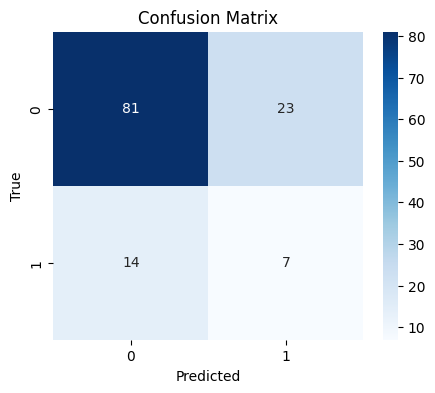

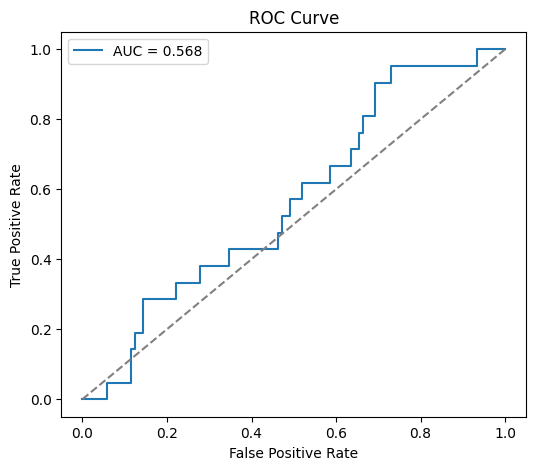

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns

def evaluate_and_plot(model, X_test, y_test, device=DEVICE):
    model.eval()
    Xt = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = model(Xt).cpu().numpy().flatten()
    preds = (probs > 0.5).astype(int)
    # metrics
    print("Classification Report:\n", classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return probs, preds

# call
probs, preds = evaluate_and_plot(model, X_test, y_test)
